# The Power of Parallel Processing feat. multithreading and multiprocessing

If you've worked with data, chances are you've had to deal with large datasets. and I mean LARGE!

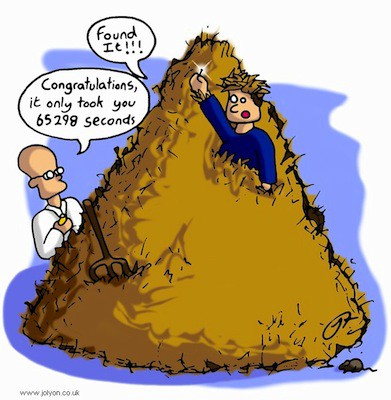

When working with large datasets, one consequence is slower processing. To avoid spending lots of time waiting around, one way is to optimize the runtime of your code by using parallel processing. Parallel Processing is nothing new to us. Here's an example: Imagine you're an EQ data analyst and you find out there are 3 reports waiting to be done for a specific client. You can either do all 3 reports yourself one by one, or get 2 other data analysts to help you out perhaps by taking one part in each report or doing one report each. Parallel processing is the second option.

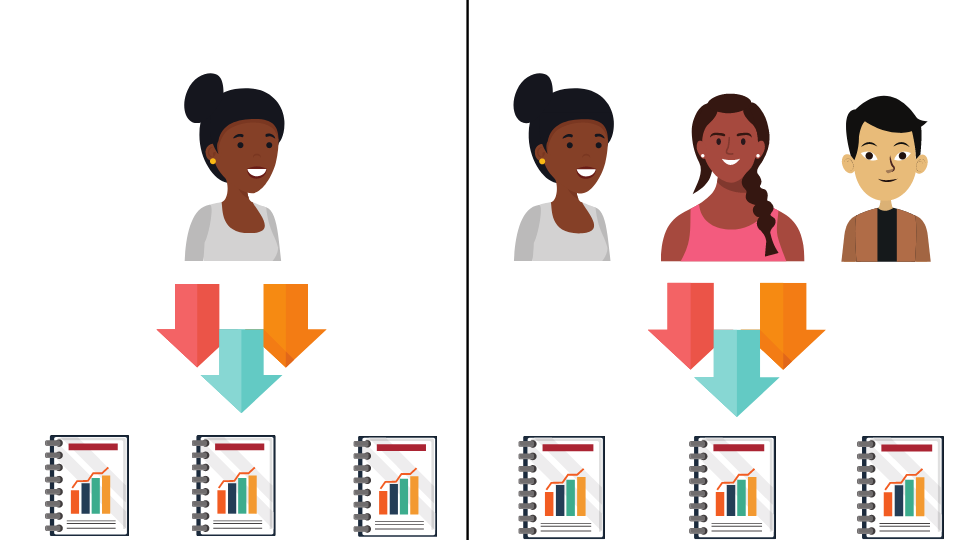

Python offers this capability of parallel processing in 2 ways, through 2 modules: multiprocessing and threading!

# What is multiprocessing?

Python was designed this in mind: computers would only have one core. One process to be run by the one core at a time. Process is an executable program (so running some code) with its own memory space. But nowadays, that's not the case- computers have multiple cores. Since Python was not designed to have multiple processes run at the same time so there was potential of memory getting mixed up between the processes. It's like suddenly being able to read someone else's thoughts all of a sudden which can get chaotic. So Python has a Global Interpreter Lock (GIL) in place to help manage memory management and run one process with one core at a time. But this means Python doesn't effectively use all of the cores that are at its disposal. That's where multiprocessing comes in: create multiple processes with its own memory space for each core.
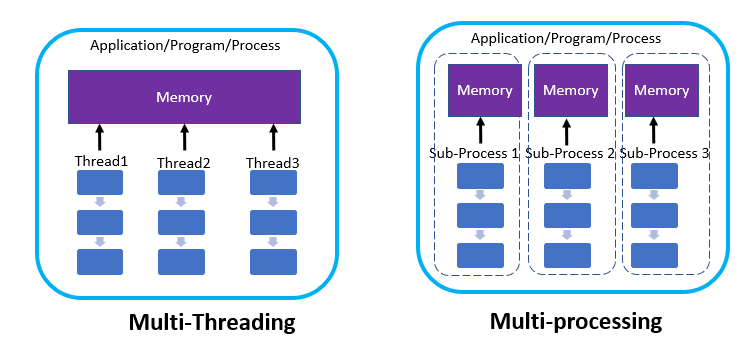

Multiprocessing bypasses GIL and uses all cores (one process per core). You'll see the speed difference in a bit through an example with pandas and Modin. An analogy of this would be 3 data analysts working on 1 report as opposed to 1 data analyst working on 3 reports.

# When would you use multiprocessing?

This method is great for CPU-intensive processes like deep analyses, heavy filtering and data manipulation. By having multiple processes, you lighten the load instead of one process doing all of the work, like in the data analyst scenario.

# Modin: An example of multiprocessing
....

# You mentioned threading, what is multithreading?

If the tasks aren't CPU-intensive such as data fetching and other I/O operations like web scraping, we can leverage threading. Threads are components of a process that work in parallel and share the same memory space. As mentioned earlier, a process is executable code with its own memory space. When data fetching, one process is enough (instead of multiple processes) since the processor will be waiting around for data to come back so we can fetch data in parallel by using threads. Python will execute one thread at a time utilizing the one process.

An example is: think about multiple people editing a google document in real-time. The google document is one memory space and multiple people are adding text to this document. Think of each person as a thread. In our data analyst example, it's like 3 analysts working on one report to speed up the process. In multiprocessing, it'd be like multiple google documents being edited by 1 person each or in our data analyst example, 1 data analyst doing 1 report each.

### Multithreading
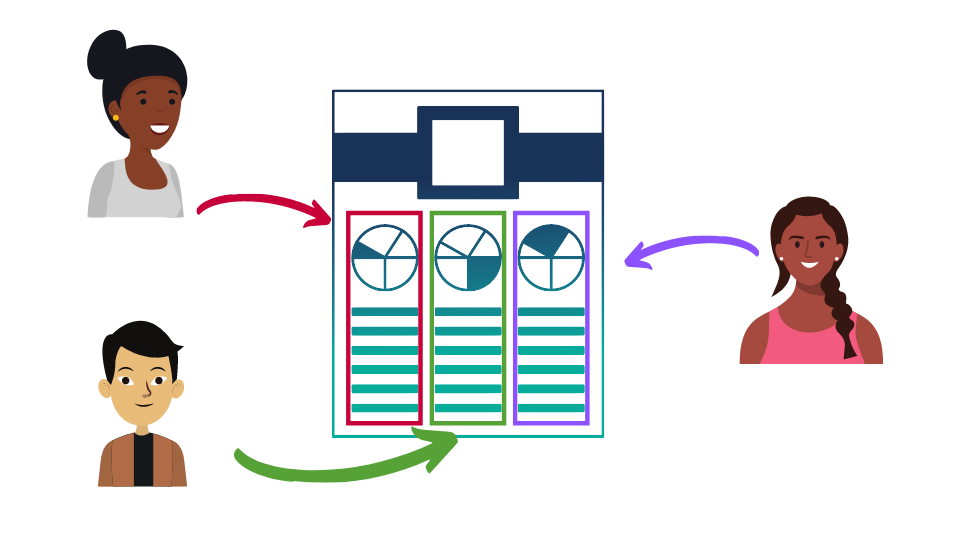

### Multiprocessing
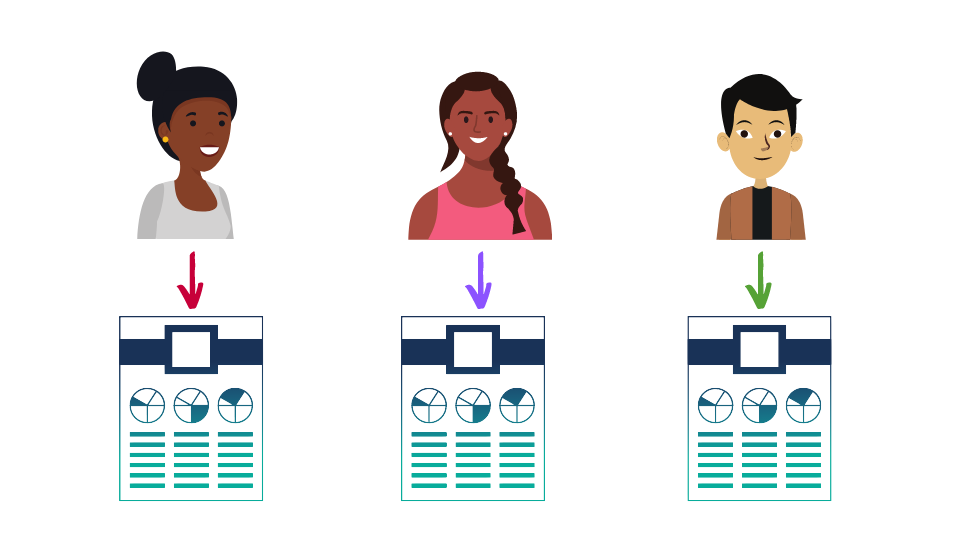

# So when would we use threading?

1. Creating processes can be a bit slow so if the code that you are running is not CPU-intensive such as data fetching, threading is a great option. Creating threads is much more lightweight than creating processes. 
2. Sharing objects is easier between threads since they share the same memory space so if you're fetching from many different areas and combining the data, threading is good.
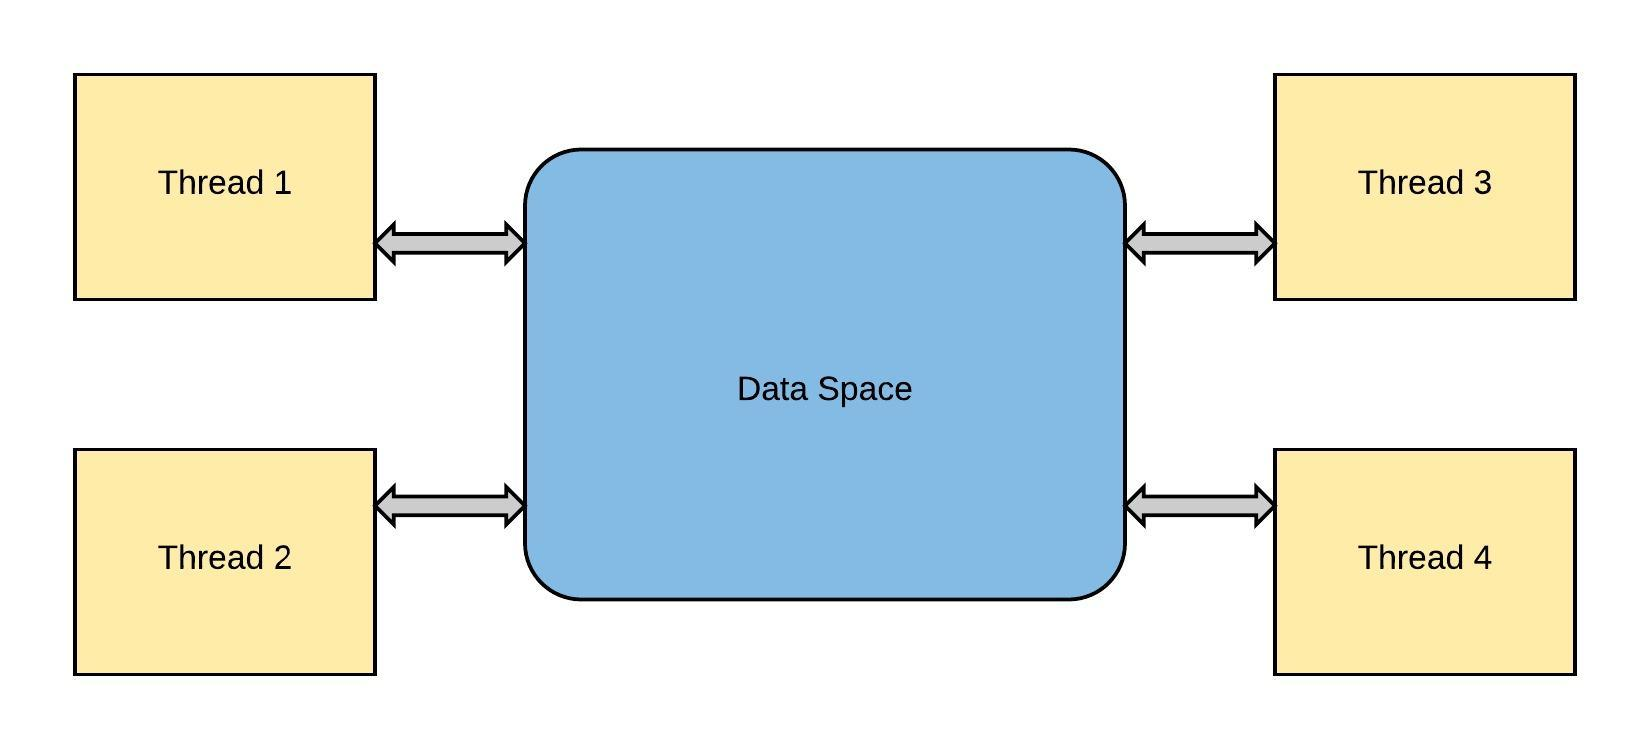

# When should we not use threading?

1. There is overhead associated with managing threads
2. Increases the complexity of the program, which can make debugging more difficult

# An example of multithreading using ThreadPoolExecutor

We use multithreading quite a bit in locussdk as well as the backend providing the data into locussdk for LOCUS Notebook. 

`ThreadPoolExecutor` is one way to use multithreading. What it does is it creates threads and groups them altogether in one pool of memory. Based on the number of threads, each thread simultaneously takes on a task. Once it's done, if there is information sent back, the information is stored in `as_completed`. One example is getting a list of all external datasets a.k.a the connections made in Connection Hub in locussdk.

```python
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List

import requests

from locussdk.base import get_client
from locussdk.user_access import get_whitelabel

def get_all_external_datasets() -> List[dict]:
    """Retrieve list of externally uploaded datasets that are accesible for query

    Returns:
        List[dict]: Metadata for each available dataset like name, source_id, and others
    """
    c = get_client()
    params = {'category': 'external_data', 'inclMeta': 1}  # include metadata
    ml_datasets = c.get('/ml/views', params=params)
    ml_datasets.raise_for_status()
    ml_datasets = ml_datasets.json()

    locus_datasets = []
    threads = 8
    locus_tasks = []

    def get_connections_per_wl(item):
        params = {'whitelabel': item['whitelabelid']}
        connections = []
        try:
            wl_datasets = c.get('/connections', params=params)
            wl_datasets.raise_for_status()
            connections = wl_datasets.json()
            return connections
        except requests.exceptions.HTTPError:
            return connections

    with ThreadPoolExecutor(max_workers=threads) as executor:
        whitelabels = get_whitelabel()
        for wl in whitelabels:
            locus_tasks.append(executor.submit(get_connections_per_wl, wl))

        for future in as_completed(locus_tasks):
            locus_datasets.extend(future.result())

    return [{
        'name': ml['name'],
        'source_id': ml['view']['conn_id'],
        'view_id': ml['view']['id'],
        'columns': list(ml['columns'].keys()),
        'created': locus['created'],
        'updated': locus['updated'],
        'whitelabel': locus['whitelabel'],
        'customer': locus['customer'],
        'upload_type': locus['type'],
        'is_syncing': locus['is_syncing'],
        'last_sync': locus['last_sync']
    } for ml in ml_datasets for locus in locus_datasets
        if ml['view']['conn_id'] == locus['id']]
```

# Sources

- [https://blog.floydhub.com/multiprocessing-vs-threading-in-python-what-every-data-scientist-needs-to-know/](https://blog.floydhub.com/multiprocessing-vs-threading-in-python-what-every-data-scientist-needs-to-know/)
- [https://timber.io/blog/multiprocessing-vs-multithreading-in-python-what-you-need-to-know/](https://timber.io/blog/multiprocessing-vs-multithreading-in-python-what-you-need-to-know/)
- [https://www.educative.io/edpresso/what-is-multithreading-in-python](https://www.educative.io/edpresso/what-is-multithreading-in-python)